# Imports and Data Loader

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision.datasets import MNIST
from PIL import Image
import random
import imutils
import cv2
import pickle

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
    ])
batch_size = 100
learning_rate = 0.1

In [ ]:
colors_arr = [(203, 215, 214),(209, 84, 69), (201, 235, 52),(8, 218, 83), (222, 55, 216),(83, 52, 235),(174, 52, 235),  (33, 228, 235), (79, 67, 66), (240, 172, 14) ]

In [ ]:
class Change_Color(MNIST):
  def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
    super(Change_Color, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)

  def __getitem__(self,index ):
    image, label = self.data[index], self.targets[index]
    image_np =  image.numpy()
    black_indicator = 0

    #Resize the vector to fit RGB
    rgb_img = cv2.cvtColor(image_np,cv2.COLOR_GRAY2RGB)
    #Generate random color
    int_label = int(label)
    nd_color = random.choice(colors_arr)

    rgb_img =  np.where(rgb_img>black_indicator, nd_color, rgb_img).astype(np.uint8)
    image_np= Image.fromarray(rgb_img)

    if self.transform is not None:
        final_image = self.transform(rgb_img)
    if self.target_transform is not None:
        label = self.target_transform(label)


    return final_image, label

In [ ]:
transform = transforms.ToTensor()
train_dataset = Change_Color(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/train-images-idx3-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/train-labels-idx1-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/t10k-images-idx3-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/t10k-labels-idx1-ubyte.gz to ./data/Change_Color/raw



In [ ]:
#upload the colored dataset :)
for i in range(len(train_dataset)):
    train_dataset.__getitem__(i)

In [ ]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  ax = []

  for i in range(columns * rows):
    img, label = dataset[i]
    img = img.T
    np_arr = img.numpy()
    flipVertical = cv2.flip(np_arr, 0)
    rotated_image = imutils.rotate(flipVertical, angle = -90)
    ax.append(fig.add_subplot(rows, columns, i + 1))
    plt.imshow(rotated_image)
    plt.axis('off')

  plt.show()

<ipython-input-8-9ce8ff5865b9>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  img = img.T


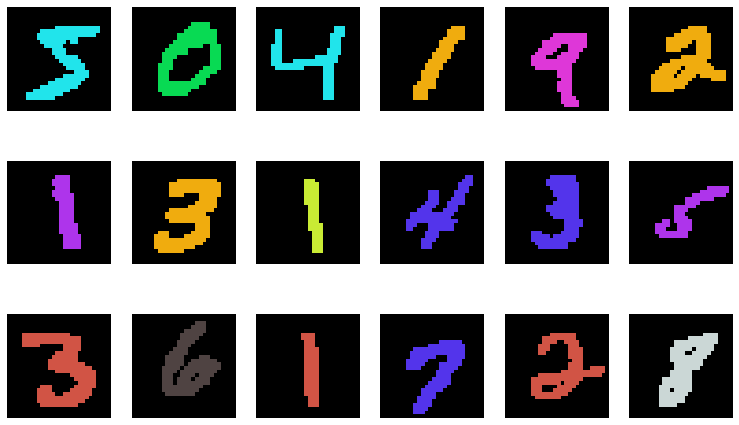

In [ ]:
plot_dataset_digits(train_dataset)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100,  shuffle=True)

# Train Continuous VAE

In [ ]:
class Encoder_Continuous(nn.Module):
  def __init__(self, latent_dims):
    super(Encoder_Continuous, self).__init__()
    self.linear1 = nn.Linear(28*28*3, 512)
    self.to_mean_logvar = nn.Linear(512, 2*latent_dims)

  def reparametrization_trick(self, mu, log_var):
    # Using reparameterization trick to sample from a gaussian
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
    self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return self.reparametrization_trick(mu, log_var)

In [ ]:
class Decoder_Continuous(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder_Continuous, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 28*28*3)

  def forward(self, z):
    z = F.relu(self.linear1(z))
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 3, 28, 28))

In [ ]:
class Vae_Continous(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()
    self.encoder = Encoder_Continuous(latent_dims)
    self.decoder = Decoder_Continuous(latent_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [ ]:
def train_continous(vae, data, epochs):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)

    for epoch in range(epochs):
        print(f'epoch num is:{epoch}')
        for i, (images, labels) in enumerate(data):
            images = images.to(device) # GPU
            opt.zero_grad()
            img_hat = vae(images)
            loss = F.binary_cross_entropy(img_hat, images, reduction='sum') + vae.encoder.kl
            loss.backward()
            opt.step()


    return vae

In [ ]:
z_dim=2
vae_continous = Vae_Continous(z_dim).to(device) # GPU
vae_continous = train_continous(vae_continous, data_loader, epochs=20)

epoch num is:0
epoch num is:1
epoch num is:2
epoch num is:3
epoch num is:4
epoch num is:5
epoch num is:6
epoch num is:7
epoch num is:8
epoch num is:9
epoch num is:10
epoch num is:11
epoch num is:12
epoch num is:13
epoch num is:14
epoch num is:15
epoch num is:16
epoch num is:17
epoch num is:18
epoch num is:19


In [ ]:
with open("train_hw2_vae_cont_206238891.pkl", "wb") as f:
  pickle.dump(vae_continous, f)

# Train Discrete VAE

In [ ]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)

    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft

    return y.reshape(bs, N*K)

In [ ]:
class DiscreteVAE(nn.Module):
    def __init__(self, latent_dim, categorical_dim):
        super(DiscreteVAE, self).__init__()

        self.fc1 = nn.Linear(784*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784*3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.N = latent_dim
        self.K = categorical_dim

    def encoder(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decoder(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        q = self.encoder(x.view(-1, 784*3))
        q_y = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decoder(z), F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

In [ ]:
N = 6
K = 25  # one-of-K vector

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

In [ ]:
vae_discrete = DiscreteVAE(N, K).to(device)

optimizer = torch.optim.Adam(vae_discrete.parameters(), lr=1e-3)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28*3), reduction='sum') / x.shape[0]

    log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD


def train_discrete(num_epochs, temp=1.0, hard=False):
    vae_discrete.train()
    train_loss = 0
    total = 0
    for epoch in range(num_epochs):
        print(f'epoch num:{epoch}')
        for batch_idx, (x, _) in enumerate(data_loader):
            optimizer.zero_grad()
            x_hat, qy = vae_discrete(x, temp, hard)
            loss = loss_function(x_hat, x, qy)
            loss.backward()
            total += len(x)
            train_loss += loss.item() * len(x)
            optimizer.step()
            if batch_idx % 100 == 1:
                temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)

            #if (batch_idx+1) % 200==0:
              #print('Epoch [%d/%d], Iter [%d/%d]' %(epoch+1, num_epochs, batch_idx+1, len(train_loader)))


In [ ]:
train_discrete(20, temp, hard)

epoch num:0
epoch num:1
epoch num:2
epoch num:3
epoch num:4
epoch num:5
epoch num:6
epoch num:7
epoch num:8
epoch num:9
epoch num:10
epoch num:11
epoch num:12
epoch num:13
epoch num:14
epoch num:15
epoch num:16
epoch num:17
epoch num:18
epoch num:19


In [ ]:
with open("train_hw2_vae_dis_206238891.pkl", "wb") as f:
  pickle.dump(vae_discrete, f)

# Train Continuous and Discrete VAE

In [ ]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)

    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft

    return y.reshape(bs, N*K)

In [ ]:
class VAE_Combined(nn.Module):
  def __init__(self, z_dim,N,K):
    super(VAE_Combined, self).__init__()
    self.fc1 = nn.Linear(3*28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc_to_d = nn.Linear(256, N * K)
    self.fc_to_n = nn.Linear(256, 2*z_dim)

    self.fc3 = nn.Linear(z_dim + N*K, 256)
    self.fc4 = nn.Linear(256, 512)
    self.fc5 = nn.Linear(512, 28*28*3)

    self.N = N
    self.K = K
    self.normal_latent_dim = z_dim

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def reparametrization_trick(self, mu, log_var):
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def encoder_normal(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc_to_n(h2)
    mu, log_var = torch.split(h3,self.normal_latent_dim, dim=-1)
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    z = self.reparametrization_trick(mu, log_var)
    return z,kl

  def encoder_discrete(self, device, x, temp, hard):
    h1 = self.relu(self.fc1(x))
    h2 = self.relu(self.fc2(h1))
    q =  self.relu(self.fc_to_d(h2))
    q_y = q.view(q.size(0), self.N, self.K)
    z = gumbel_softmax(q_y, temp, hard)
    return z, F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

  def encoder_combined(self, device, x, temp, hard):
    input = x.view(-1, 28*28*3)
    z1_cont, kl = self.encoder_normal(input)
    z2_dis, qy = self.encoder_discrete(device, input, temp, hard)
    z_combined = torch.cat((z1_cont, z2_dis), dim = 1)
    return z_combined, qy, kl

  def decoder(self,x):
    output = F.relu(self.fc3(x))
    output = F.relu(self.fc4(output))
    output = self.sigmoid(self.fc5(output))
    output = output.view(-1, 3,28,28)
    return output

  def forward(self, device, input, temp, hard):
    x, qy, kl = self.encoder_combined(device, input, temp, hard)
    x = self.decoder(x)
    return x, qy, kl

In [ ]:
def loss_function(recon_x, x, qy):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0]

  log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
  KLD = torch.sum(qy * log_ratio, dim=-1).mean()

  return BCE + KLD

In [ ]:
temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003
z_dim = 2
N = 5
K = 65

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_combined = VAE_Combined(z_dim, N, K).to(device)

def train_model_combined(num_epochs, temp=1.0, hard=False):
    optimizer = torch.optim.Adam(model_combined.parameters(), lr=1e-3)
    train_loss = 0
    for epoch in range(num_epochs):
        print(f'epoch num is:{epoch}')
        for batch_idx, (x, _) in enumerate(data_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, qy, kl = model_combined(device, x, temp, hard)
            total_loss = loss_function(x_hat, x, qy) + kl
            total_loss.backward()
            train_loss += total_loss.item()
            optimizer.step()
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)

In [ ]:
train_model_combined(20, temp, hard)

epoch num is:0
epoch num is:1
epoch num is:2
epoch num is:3
epoch num is:4
epoch num is:5
epoch num is:6
epoch num is:7
epoch num is:8
epoch num is:9
epoch num is:10
epoch num is:11
epoch num is:12
epoch num is:13
epoch num is:14
epoch num is:15
epoch num is:16
epoch num is:17
epoch num is:18
epoch num is:19


In [ ]:
with open("train_hw2_vae_combined_206238891.pkl", "wb") as f:
  pickle.dump(model_combined, f)